In [97]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [99]:
%run ../common_code.ipynb

In [101]:
data = pd.read_csv("../../datasets/california.csv")

n_features = data.shape[1]-1
n = data.shape[0]
target = "price_above_median"
features = data.columns.difference([target]).tolist()
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price_above_median
0,2.1827,26,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0
1,3.0755,32,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0
2,1.8235,40,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0
3,1.4625,37,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0
4,1.9063,13,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0


In [105]:
n

20634

In [102]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
#preprocessing


## Using gradient boosting regressor for experiments

In [107]:
model = GradientBoostingClassifier(n_estimators=30)
#model = LogisticRegression()
model.fit(data[features], data[target])

GradientBoostingClassifier(n_estimators=30)

## calculating individual errors

In [108]:
data_errors = data.copy(deep=True)
probs = model.predict_proba(data[features])[:, 1]
data_errors["inconf_error"] = (1-probs)*data[target]+(probs)*(1-data[target]) #inconfidence measure: the larger the worser inconfidence

data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,inconf_error
0,2.1827,26,4.521429,0.921429,305.0,2.178571,40.05,-122.10,0.100466
1,3.0755,32,4.623068,0.983353,3868.0,4.599287,32.77,-117.06,0.134913
2,1.8235,40,4.701149,1.126437,928.0,3.555556,37.75,-122.16,0.161211
3,1.4625,37,4.247845,1.105603,1673.0,3.605603,33.99,-118.28,0.181966
4,1.9063,13,3.453125,0.984375,286.0,4.468750,33.97,-118.16,0.164867


## discretization into gradarions

In [109]:
disc_data, pipeline_data = discretize(data_errors, features+["inconf_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,AveBedrms,AveOccup,AveRooms,HouseAge,Latitude,Longitude,MedInc,Population,inconf_error
0,0,0,0,1,2,0,0,0,0
1,0,0,0,1,0,2,0,1,0
2,0,0,0,2,1,0,0,0,0
3,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
20629,0,0,0,1,2,0,1,0,2
20630,0,0,0,0,2,0,1,0,0
20631,0,0,0,0,2,0,0,0,2
20632,0,0,0,2,2,0,0,0,2


In [110]:
pipeline_data["cont_features"]

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'inconf_error']

## automatic adjustment of gradations
for features with unfair gradations kmeans split
in general gradations are up to reseacher reasoning

In [111]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [2,3, 5, 4]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7], v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

## rediscretization after the adjustment

In [112]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,inconf_error
0,0,1,0,0,0,0,2,0,0
1,0,1,1,0,2,2,0,2,0
2,0,2,1,2,1,2,1,0,0
3,0,1,0,2,2,2,0,1,0
4,0,0,0,0,0,2,0,1,0
...,...,...,...,...,...,...,...,...,...
20629,1,1,2,1,1,1,2,0,2
20630,1,0,2,1,0,1,2,0,0
20631,0,0,1,1,1,2,2,0,2
20632,0,2,1,0,0,0,2,0,2


In [114]:
disc_data['inconf_error'].value_counts()

inconf_error
0    12183
1     5627
2     2824
Name: count, dtype: int64

In [115]:
current_error = data_errors["inconf_error"].sum()/n
current_error

0.2733692761372762

In [116]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [117]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'MedInc': 3,
 'HouseAge': 3,
 'AveRooms': 3,
 'AveBedrms': 3,
 'Population': 3,
 'AveOccup': 3,
 'Latitude': 3,
 'Longitude': 3,
 'inconf_error': 3}

In [118]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("inconf_error", x) for x in features]

In [119]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [120]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,HouseAge,Discrete,disc,[],[]
1,Longitude,Discrete,disc,[HouseAge],[disc]
2,Latitude,Discrete,disc,"[HouseAge, Longitude]","[disc, disc]"
3,AveOccup,Discrete,disc,"[HouseAge, Latitude]","[disc, disc]"
4,Population,Discrete,disc,"[HouseAge, AveOccup, Latitude]","[disc, disc, disc]"
5,AveBedrms,Discrete,disc,"[HouseAge, Population, AveOccup]","[disc, disc, disc]"
6,AveRooms,Discrete,disc,"[HouseAge, Population, AveOccup]","[disc, disc, disc]"
7,MedInc,Discrete,disc,"[AveRooms, AveBedrms, Latitude, Longitude]","[disc, disc, disc, disc]"
8,inconf_error,Discrete,disc,"[MedInc, AveOccup, Latitude, Longitude]","[disc, disc, disc, disc]"


In [121]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [122]:
bn.distributions

{'HouseAge': {'cprob': [0.34578850441019676,
   0.414655423088107,
   0.23955607250169622],
  'vals': ['0', '1', '2']},
 'Longitude': {'cprob': {"['1']": [0.337190275829827,
    0.511921458625526,
    0.15088826554464704],
   "['2']": [0.4466922921302853, 0.48270281205745497, 0.07060489581225976],
   "['0']": [0.416958654519972, 0.28100911002102313, 0.3020322354590049]},
  'vals': ['0', '1', '2']},
 'Latitude': {'cprob': {"['1', '0']": [0.029116117850953208,
    0.692894280762565,
    0.2779896013864818],
   "['1', '2']": [0.9984508133230054, 0.001549186676994578, 0.0],
   "['1', '1']": [0.9061643835616439,
    0.08561643835616438,
    0.00821917808219178],
   "['2', '0']": [0.009057971014492754,
    0.8269927536231884,
    0.16394927536231885],
   "['2', '2']": [1.0, 0.0, 0.0],
   "['2', '1']": [0.9446772841575859, 0.055322715842414084, 0.0],
   "['0', '0']": [0.05310924369747899, 0.5452100840336135, 0.4016806722689076],
   "['0', '2']": [0.9990719257540603, 0.0009280742459396752, 0.0

## applying YODO

In [123]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

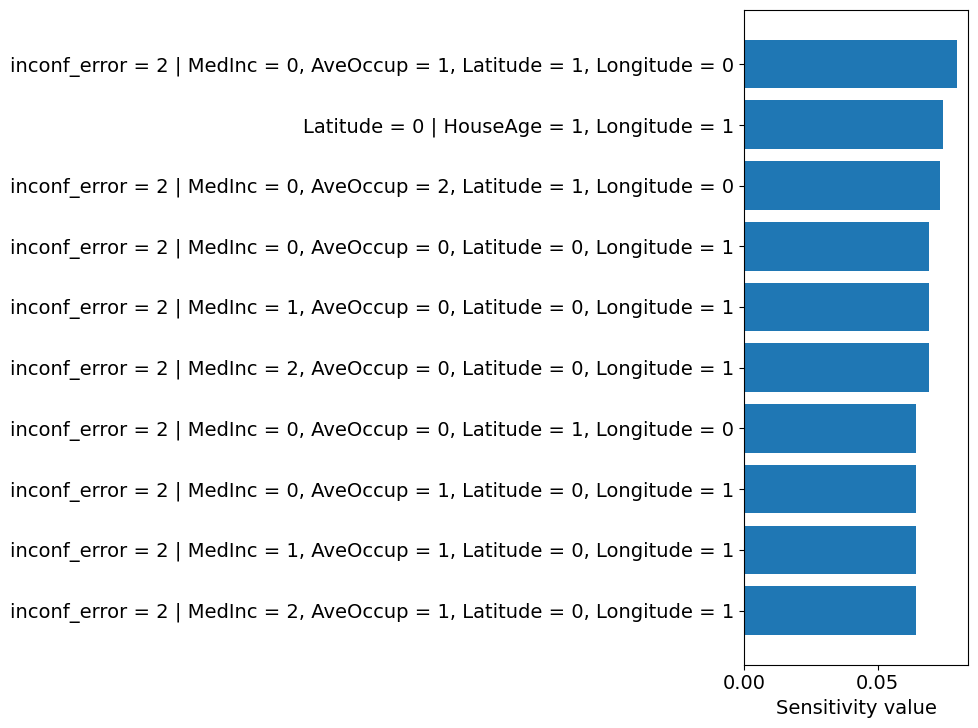

In [125]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'inconf_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии низких и средних значений MedInc, AveOccup, Latitude, Longitude

In [126]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score

In [127]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

## applying SHAP

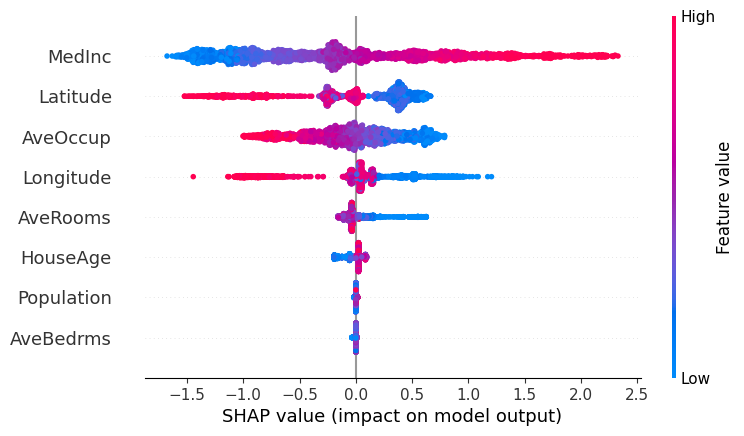

In [128]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['inconf_error']==2][features])
shap.plots.beeswarm(shap_values)

трактование: больше всего на предскзаания для наблюдений с высокой ошибкой влияет MedInc, Latitude, AveOccup, Longitude, большее влияние от высоких значений (влияние на результат, дающий высокую ошибку)

## applying our approarch

In [129]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,MedInc_0,MedInc_1,MedInc_2,HouseAge_0,HouseAge_1,HouseAge_2,AveRooms_0,AveRooms_1,AveRooms_2,AveBedrms_0,...,AveOccup_2,Latitude_0,Latitude_1,Latitude_2,Longitude_0,Longitude_1,Longitude_2,inconf_error_0,inconf_error_1,inconf_error_2
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,1,1,0,0,1,0,0
1,1,0,0,0,1,0,0,1,0,1,...,1,1,0,0,0,0,1,1,0,0
2,1,0,0,0,0,1,0,1,0,0,...,1,0,1,0,1,0,0,1,0,0
3,1,0,0,0,1,0,1,0,0,0,...,1,1,0,0,0,1,0,1,0,0
4,1,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20629,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
20630,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
20631,1,0,0,1,0,0,0,1,0,0,...,1,0,0,1,1,0,0,0,0,1
20632,1,0,0,0,0,1,0,1,0,1,...,0,0,0,1,1,0,0,0,0,1


In [130]:
from itertools import product

In [131]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "inconf_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "inconf_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-22 19:05:46,891 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,893 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,895 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,897 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,898 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,900 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,901 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,902 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,903 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 19:05:46,904 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [132]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,AveOccup_0,Discrete,disc,[],[]
1,Latitude_2,Discrete,disc,[AveOccup_0],[disc]
2,MedInc_0,Discrete,disc,"[AveOccup_0, Latitude_2]","[disc, disc]"
3,Latitude_1,Discrete,disc,"[MedInc_0, AveOccup_0]","[disc, disc]"
4,AveRooms_0,Discrete,disc,"[MedInc_0, AveOccup_0, Latitude_1, Latitude_2]","[disc, disc, disc, disc]"
5,AveBedrms_2,Discrete,disc,"[MedInc_0, AveRooms_0, AveOccup_0]","[disc, disc, disc]"
6,MedInc_1,Discrete,disc,"[AveRooms_0, AveBedrms_2, AveOccup_0, Latitude_2]","[disc, disc, disc, disc]"
7,AveRooms_2,Discrete,disc,"[MedInc_0, MedInc_1, AveBedrms_2, AveOccup_0, ...","[disc, disc, disc, disc, disc]"
8,MedInc_2,Discrete,disc,"[AveRooms_2, AveBedrms_2, Latitude_2]","[disc, disc, disc]"
9,AveRooms_1,Discrete,disc,"[MedInc_1, MedInc_2, AveBedrms_2, Latitude_1, ...","[disc, disc, disc, disc, disc]"


In [133]:
info = gbn.get_info()
info.iloc[21, 3]

['MedInc_0', 'MedInc_2', 'HouseAge_0', 'AveOccup_2', 'Latitude_2']

In [134]:
gbn.custom_mapper

In [ ]:
gbn.plot("calif_regr.html")

In [136]:
dfeat = ["MedInc", "AveOccup", "Latitude", "Longitude"]
dcat = [0, 1, 0, 1]

dfeatshap = ["MedInc", "AveOccup", "Latitude", "Longitude"]
dcatshap = [2, 2, 2, 2]

dfeatbn = ["MedInc", "MedInc", "HouseAge", "Latitude", "AveOccup"]
dcatbn = [0, 2, 0, 2, 2]


d_dict={
    'yodo': [["MedInc", "AveOccup", "Latitude", "Longitude"], [0, 1, 0, 1]],
    'bn': [["MedInc", "AveOccup", "Latitude", "Longitude"], [2, 2, 2, 2]],
    'shap': [["MedInc", "MedInc", "HouseAge", "Latitude", "AveOccup"], [0, 2, 0, 2, 2]]
}

bn = n//2


In [138]:
data.shape, n

((20634, 9), 20634)

## run 1: alpha=0.8

In [139]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.8, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [48:25<00:00, 11.62s/it]


In [140]:
stats_res['avg_n_dropped']

{'yodo': 727.284, 'bn': 729.184, 'shap': 734.688, 'init': -1, 'random': -1}

In [141]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.03524687409130561,
 'bn': 0.03533895512261316,
 'shap': 0.03560569933120093,
 'init': -4.846370068818455e-05,
 'random': -4.846370068818455e-05}

In [142]:
def plot_scores(metrics, graph_label, k):
    avg_metric = {}
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        avg_metric[names_mapping[name]] = sum(metrics[name][k])/len(metrics[name][k])

    plt.legend()
    plt.xlabel(graph_label)
    return avg_metric

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [143]:
def extended_experiments_output(stats_dictionary, metrics_labels_list):
    tbl_scores = pd.DataFrame(columns=['method', 'metric', 'value'])
    i=0
    for k, label in enumerate(metrics_labels_list):
        plt.figure()
        avg_stats = plot_scores(stats_dictionary, label, k)
        for key, val in avg_stats.items():
            tbl_scores.loc[i, :] = [key, label, val]
            i+=1
    return pd.pivot(tbl_scores, index='metric', columns='method')


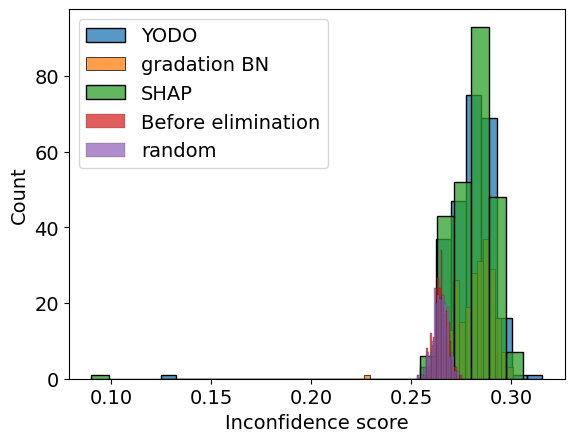

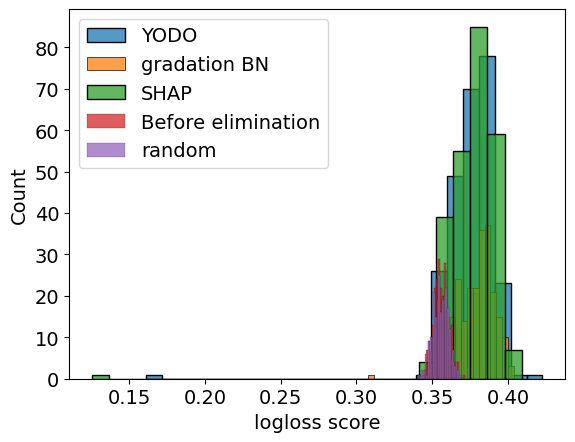

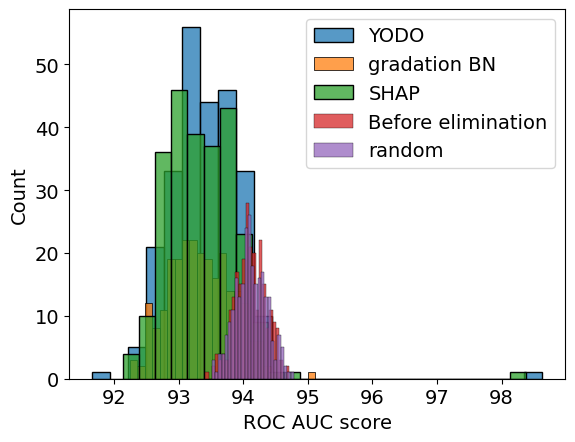

In [145]:
res_train_tbl = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [146]:
res_train_tbl

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.264765   0.280447   0.280235     0.281199   
ROC AUC score               94.110527  93.351745  93.399084    93.346404   
logloss score                0.355775   0.376668   0.376066     0.377553   

                               
method                 random  
metric                         
Inconfidence score   0.264617  
ROC AUC score       94.116705  
logloss score        0.355585

In [147]:
print(res_train_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.264765 & 0.280447 & 0.280235 & 0.281199 & 0.264617 \\
ROC AUC score & 94.110527 & 93.351745 & 93.399084 & 93.346404 & 94.116705 \\
logloss score & 0.355775 & 0.376668 & 0.376066 & 0.377553 & 0.355585 \\
\bottomrule
\end{tabular}



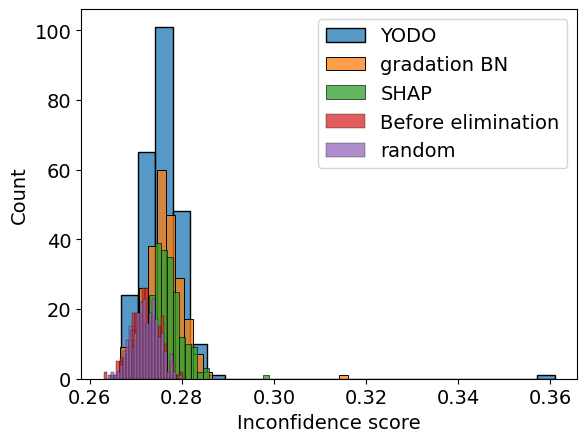

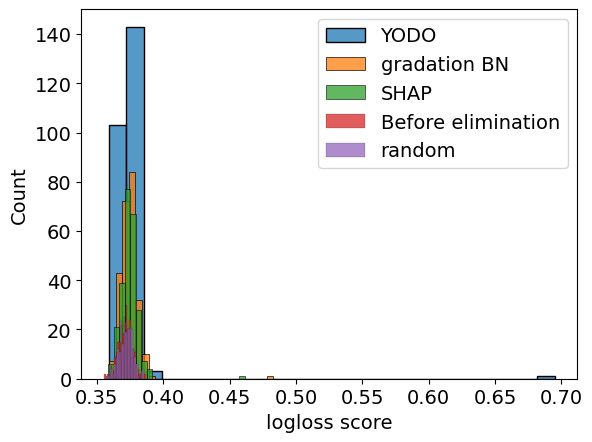

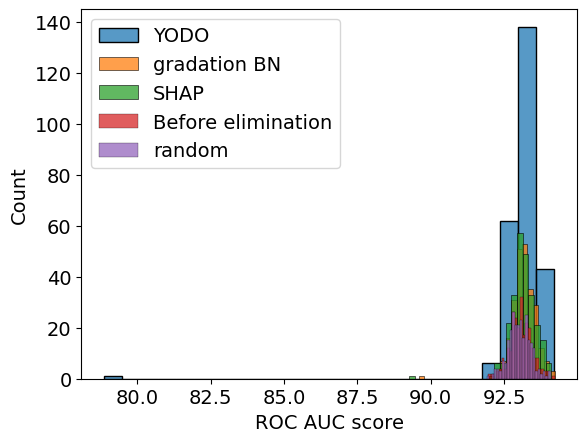

In [148]:
res_test_tbl = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [149]:
res_test_tbl

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.272084   0.275833   0.275853     0.276002   
ROC AUC score               93.073475  93.140942  93.147885    93.160092   
logloss score                0.371391   0.374572   0.374897     0.374612   

                               
method                 random  
metric                         
Inconfidence score    0.27222  
ROC AUC score       93.031097  
logloss score         0.37188

In [150]:
print(res_test_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.272084 & 0.275833 & 0.275853 & 0.276002 & 0.272220 \\
ROC AUC score & 93.073475 & 93.140942 & 93.147885 & 93.160092 & 93.031097 \\
logloss score & 0.371391 & 0.374572 & 0.374897 & 0.374612 & 0.371880 \\
\bottomrule
\end{tabular}



In [151]:
def avg_prcnt_change(stats, name1, name2, metric_num, direction=1):
    cnt = len(stats[name1][0])
    return direction*sum((a-b)/b for a, b in zip(stats[name1][metric_num], stats[name2][metric_num]))/cnt*100

In [152]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1) # ['Inconfidence score', 'logloss score', 'ROC AUC score']

-1.4434740710748917

In [153]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)

-0.8724509457424635

In [154]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)

0.09333324403656743

In [155]:
from scipy.stats import ttest_rel

In [156]:
ttest_rel(stats_res['metrics']['bn'][0], stats_res['metrics']['init'][0]) #['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=28.15163971240839, pvalue=2.452794665935668e-79, df=249)

In [157]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=15.65280620490365, pvalue=6.465775763827393e-39, df=249)

In [158]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=6.57174222491801, pvalue=2.890563030648357e-10, df=249)

In [159]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])#['Inconfidence score', 'logloss score', 'ROC AUC score']

TtestResult(statistic=4.516694684050753, pvalue=9.704294681259567e-06, df=249)

## Run 2: alpha=0.9

In [160]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [50:23<00:00, 12.09s/it]


In [161]:
stats_res['avg_n_dropped']

{'yodo': 471.232, 'bn': 385.2, 'shap': 456.064, 'init': -1, 'random': -1}

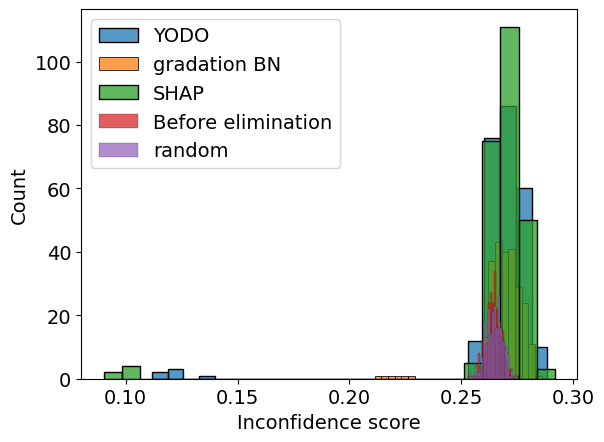

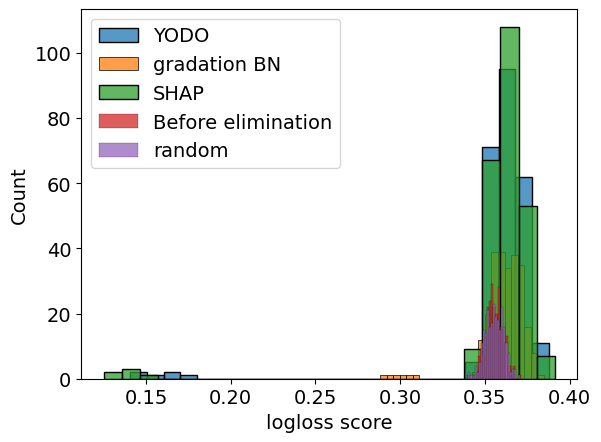

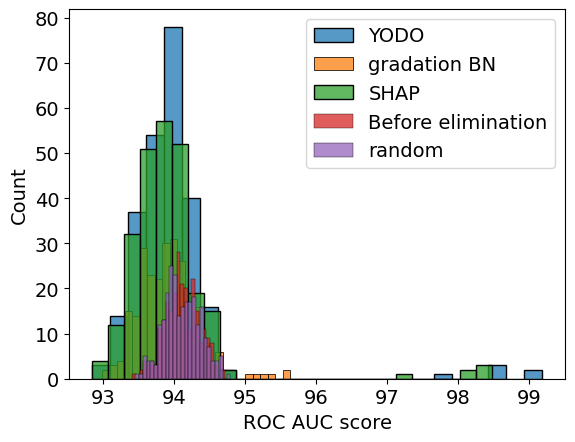

In [162]:
res_train_tbl_1 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [163]:
res_train_tbl_1

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.264765   0.266495   0.266786      0.26902   
ROC AUC score               94.110527  93.939514  93.976712    93.898602   
logloss score                0.355775   0.358186   0.358218     0.361488   

                               
method                 random  
metric                         
Inconfidence score   0.264658  
ROC AUC score       94.112647  
logloss score        0.355673

In [164]:
print(res_train_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.264765 & 0.266495 & 0.266786 & 0.269020 & 0.264658 \\
ROC AUC score & 94.110527 & 93.939514 & 93.976712 & 93.898602 & 94.112647 \\
logloss score & 0.355775 & 0.358186 & 0.358218 & 0.361488 & 0.355673 \\
\bottomrule
\end{tabular}



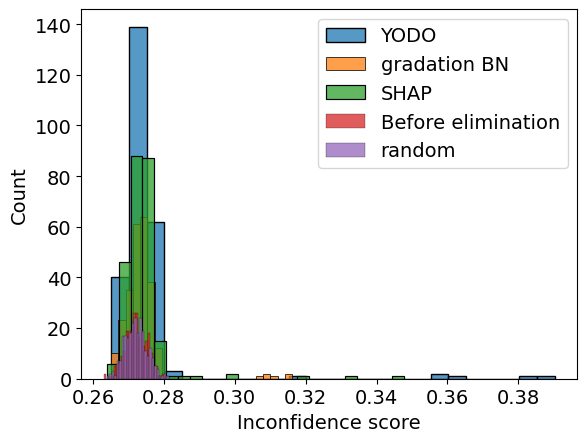

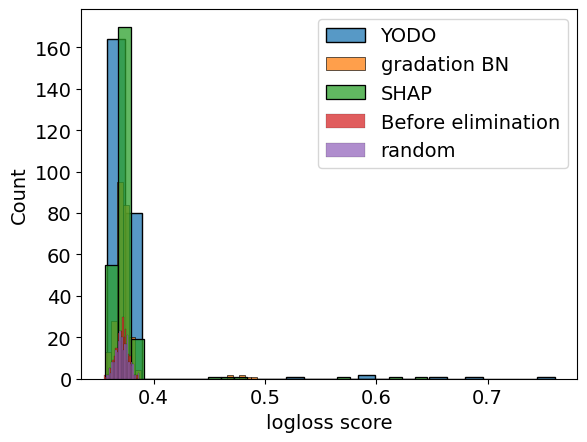

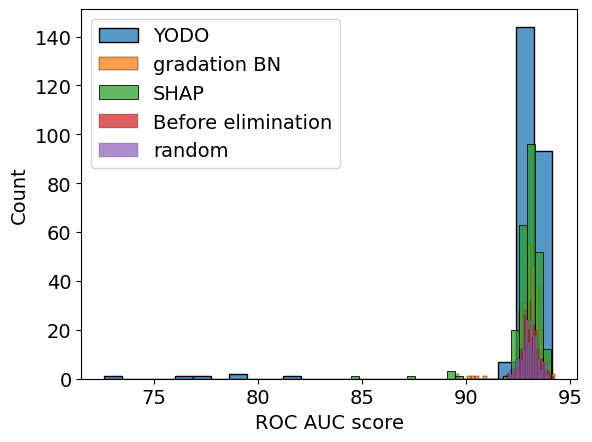

In [165]:
res_test_tbl_1 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [166]:
res_test_tbl_1

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.272084   0.274119   0.275123     0.273805   
ROC AUC score               93.073475  92.981979  92.749692    93.050355   
logloss score                0.371391   0.376189    0.37821      0.37434   

                               
method                 random  
metric                         
Inconfidence score   0.272143  
ROC AUC score       93.042157  
logloss score        0.371728

In [167]:
print(res_test_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.272084 & 0.274119 & 0.275123 & 0.273805 & 0.272143 \\
ROC AUC score & 93.073475 & 92.981979 & 92.749692 & 93.050355 & 93.042157 \\
logloss score & 0.371391 & 0.376189 & 0.378210 & 0.374340 & 0.371728 \\
\bottomrule
\end{tabular}



In [168]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.6365316560774101

In [169]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.8005253952184597

In [170]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.024543045670607454

In [171]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=4.281179374843052, pvalue=2.6550960078308105e-05, df=249)

In [172]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=2.752818796417299, pvalue=0.006343476985823766, df=249)

In [173]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=-0.7136688983789877, pvalue=0.476100325671478, df=249)

## Run 3: alpha=0.85

In [174]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    lambda x, y: roc_auc_score(x,y)*100], trials=250,alpha=0.85, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)

100%|██████████| 250/250 [49:46<00:00, 11.95s/it]


In [175]:
stats_res['avg_n_dropped']

{'yodo': 579.468, 'bn': 541.136, 'shap': 577.104, 'init': -1, 'random': -1}

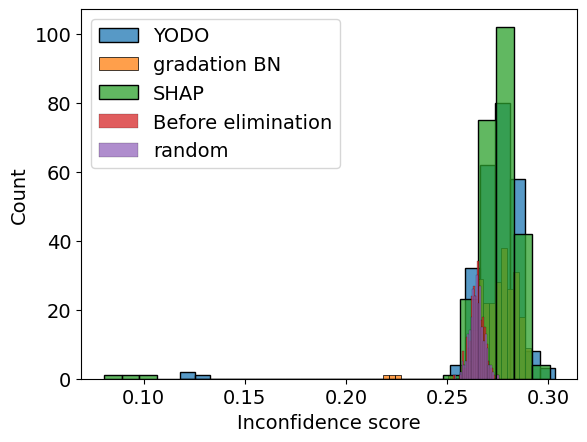

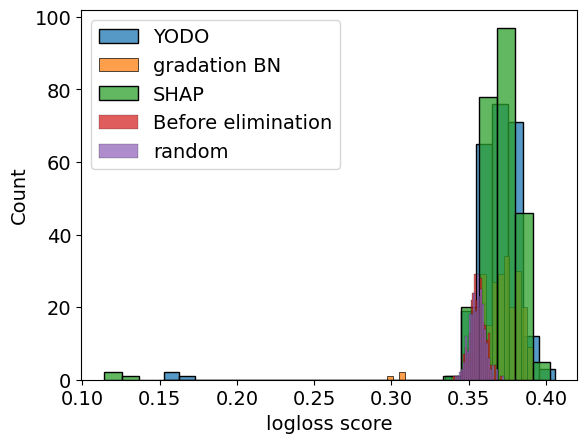

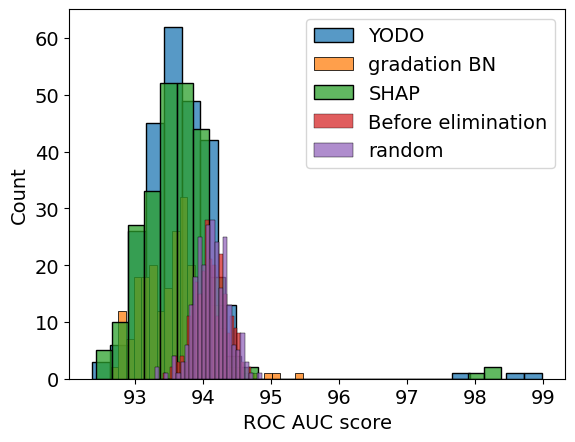

In [176]:
res_train_tbl_2 = extended_experiments_output(stats_res['metrics'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [177]:
res_train_tbl_2

value                                     \
method             Before elimination       SHAP       YODO gradation BN   
metric                                                                     
Inconfidence score           0.264765   0.273744   0.273806     0.275118   
ROC AUC score               94.110527  93.631236  93.674123    93.611981   
logloss score                0.355775   0.367843   0.367612      0.36964   

                               
method                 random  
metric                         
Inconfidence score   0.264701  
ROC AUC score       94.124281  
logloss score        0.355602

In [178]:
print(res_train_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.264765 & 0.273744 & 0.273806 & 0.275118 & 0.264701 \\
ROC AUC score & 94.110527 & 93.631236 & 93.674123 & 93.611981 & 94.124281 \\
logloss score & 0.355775 & 0.367843 & 0.367612 & 0.369640 & 0.355602 \\
\bottomrule
\end{tabular}



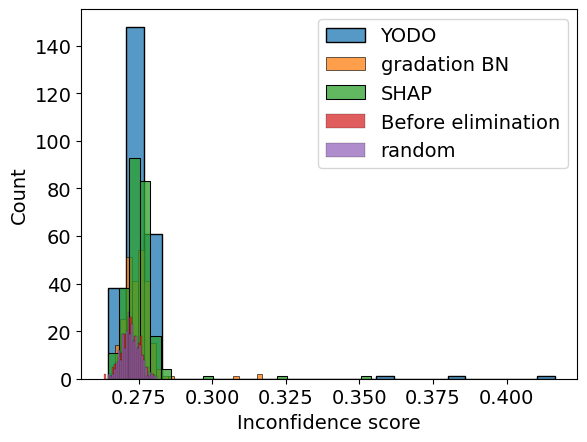

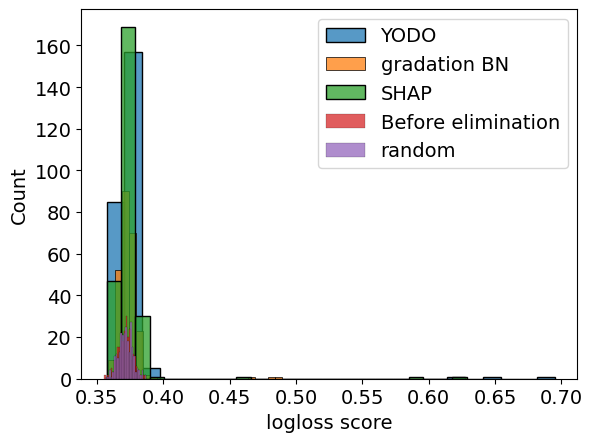

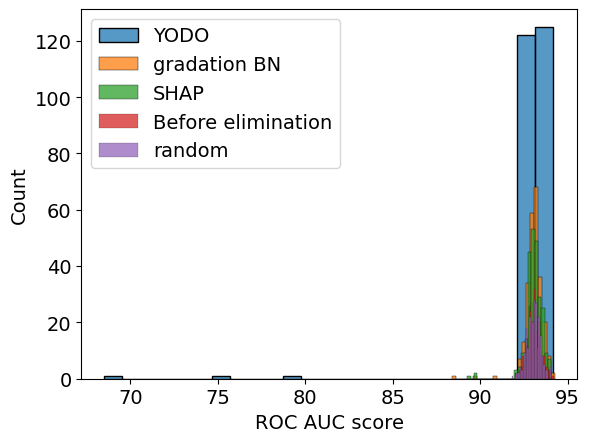

In [179]:
res_test_tbl_2 = extended_experiments_output(stats_res['metrics_test'], ['Inconfidence score', 'logloss score', 'ROC AUC score'])

In [180]:
res_test_tbl_2

value                                    \
method             Before elimination       SHAP      YODO gradation BN   
metric                                                                    
Inconfidence score           0.272084   0.275084  0.275614     0.274819   
ROC AUC score               93.073475  93.069661  92.92034    93.081232   
logloss score                0.371391    0.37559  0.376217     0.374425   

                               
method                 random  
metric                         
Inconfidence score   0.272245  
ROC AUC score       93.047363  
logloss score        0.371754

In [181]:
print(res_test_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
Inconfidence score & 0.272084 & 0.275084 & 0.275614 & 0.274819 & 0.272245 \\
ROC AUC score & 93.073475 & 93.069661 & 92.920340 & 93.081232 & 93.047363 \\
logloss score & 0.371391 & 0.375590 & 0.376217 & 0.374425 & 0.371754 \\
\bottomrule
\end{tabular}



In [182]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-1.0091314482414995

In [183]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

-0.8238708554549282

In [184]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 2, 1)#['Inconfidence score', 'logloss score', 'ROC AUC score']

0.008696047849551254

In [185]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=8.445164162325536, pvalue=2.542215690135238e-15, df=249)

In [186]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=3.8963709008122724, pvalue=0.00012554850464477577, df=249)

In [187]:
ttest_rel(stats_res['metrics_test']['bn'][2], stats_res['metrics_test']['init'][2])

TtestResult(statistic=0.2687405325482853, pvalue=0.7883518861827401, df=249)